In [26]:
import numpy as np
import pymc3 as pm
import theano.tensor as tt
import theano
import matplotlib.pyplot as plt

In [27]:
# set up the model and data
np.random.seed(5673424)
size = 20
true_intercept = 1
true_slope = 2
sigma = 1
x = np.linspace(0, 1, size)

# y = a + b*x
true_regression_line = true_intercept + true_slope * x

# add noise
y = true_regression_line + np.random.normal(0, sigma ** 2, size)
s= sigma
#s = np.identity(y.shape[0])
#np.fill_diagonal(s, sigma ** 2)

# reduced dataset
#x_coarse_0 = x[::4]
#y_coarse_0 = y[::4]
x_coarse_1 = x[::2]
y_coarse_1 = y[::2]
#s_0 = np.identity(y_coarse_0.shape[0])
#np.fill_diagonal(s_0, sigma ** 2)
#s_1 = np.identity(y_coarse_1.shape[0])
#np.fill_diagonal(s_1, sigma ** 2)

# MCMC parameters
ndraws = 1000
ntune = 500
nsub = 5
nchains = 2
seed = 98765

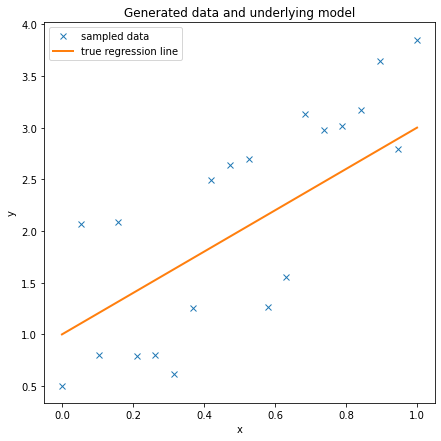

In [28]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, 'x', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);

In [29]:
class Likelihood(tt.Op):
    if theano.config.floatX == "float32":
        itypes = [tt.fvector]
        otypes = [tt.fscalar]
    else:
        itypes = [tt.dvector]
        otypes = [tt.dscalar]

    def __init__(self, x, y, pymc3_model):
        self.x = x
        self.y = y
        self.pymc3_model = pymc3_model

    def perform(self, node, inputs, outputs):
        intercept = inputs[0][0]
        x_coeff = inputs[0][1]

        temp = intercept + x_coeff * self.x
        self.pymc3_model.Q.set_value(x_coeff)
        outputs[0][0] = np.array(- (0.5 / s ** 2) * np.sum((temp - self.y) ** 2))

In [30]:
'''
class ForwardModel(tt.Op):
    if theano.config.floatX == "float32":
        itypes = [tt.fvector]
        otypes = [tt.fvector]
    else:
        itypes = [tt.dvector]
        otypes = [tt.dvector]

    def __init__(self, x, pymc3_model):
        self.x = x
        self.pymc3_model = pymc3_model

    def perform(self, node, inputs, outputs):
        intercept = inputs[0][0]
        x_coeff = inputs[0][1]

        temp = intercept + x_coeff * self.x
        self.pymc3_model.Q.set_value(x_coeff)
        outputs[0][0] = temp
'''

'\nclass ForwardModel(tt.Op):\n    if theano.config.floatX == "float32":\n        itypes = [tt.fvector]\n        otypes = [tt.fvector]\n    else:\n        itypes = [tt.dvector]\n        otypes = [tt.dvector]\n\n    def __init__(self, x, pymc3_model):\n        self.x = x\n        self.pymc3_model = pymc3_model\n\n    def perform(self, node, inputs, outputs):\n        intercept = inputs[0][0]\n        x_coeff = inputs[0][1]\n\n        temp = intercept + x_coeff * self.x\n        self.pymc3_model.Q.set_value(x_coeff)\n        outputs[0][0] = temp\n'

In [31]:
coarse_models = []
mout = []
'''
with pm.Model() as coarse_model_0:            
    Q = pm.Data('Q', float(0.0))
    #Sigma_e = pm.Data('Sigma_e', s_0)

    # Define priors
    intercept = pm.Normal('Intercept', 0, sigma=20)
    x_coeff = pm.Normal('x', 0, sigma=20)

    theta = tt.as_tensor_variable([intercept, x_coeff])

    #mout.append(ForwardModel(x_coarse_0, coarse_model_0))
        
    # Define likelihood
    #likelihood = pm.MvNormal('y', mu=mout[0](theta),
    #                      cov=Sigma_e, observed=y_coarse_0)
    
    mout.append(Likelihood(x_coarse_0, y_coarse_0, coarse_model_0))
    pm.Potential('likelihood', mout[0](theta))

    coarse_models.append(coarse_model_0)
'''
with pm.Model() as coarse_model_1:    
    Q = pm.Data('Q', float(0.0))
    #Sigma_e = pm.Data('Sigma_e', s_1)

    # Define priors
    intercept = pm.Normal('Intercept', 0, sigma=20)
    x_coeff = pm.Normal('x', 0, sigma=20)

    theta = tt.as_tensor_variable([intercept, x_coeff])

    #mout.append(ForwardModel(x_coarse_1, coarse_model_1))    

    # Define likelihood
    #likelihood = pm.MvNormal('y', mu=mout[1](theta),
    #                      cov=Sigma_e, observed=y_coarse_1)
    
    mout.append(Likelihood(x_coarse_1, y_coarse_1, coarse_model_1))
    pm.Potential('likelihood', mout[0](theta))

    coarse_models.append(coarse_model_1)



In [32]:
with pm.Model() as model:    
    Q = pm.Data('Q', float(0.0))
    #Sigma_e = pm.Data('Sigma_e', s)

    # Define priors
    intercept = pm.Normal('Intercept', 0, sigma=20)
    x_coeff = pm.Normal('x', 0, sigma=20)

    theta = tt.as_tensor_variable([intercept, x_coeff])

    #mout.append(ForwardModel(x, model))

    # Define likelihood
    #likelihood = pm.MvNormal('y', mu=mout[2](theta),
    #                      cov=Sigma_e, observed=y)
    
    mout.append(Likelihood(x, y, model))
    pm.Potential('likelihood', mout[1](theta))

    step = pm.MLDA(coarse_models=coarse_models,
                   subsampling_rates=nsub,
                variance_reduction=True,
                store_Q_fine=True)
    
    step2 = pm.DEMetropolisZ()

    trace = pm.sample(draws=ndraws, step=step,
                   chains=nchains, tune=ntune, cores=1,
                   discard_tuned_samples=True,
                   random_seed=seed)
    
    trace2 = pm.sample(draws=ndraws, step=step2,
                   chains=nchains, tune=ntune, cores=1,
                   discard_tuned_samples=True,
                   random_seed=seed)

/Users/gmingas/projects/pymc3-vr/pymc3/step_methods/metropolis.py:1096: UserWarning: The MLDA implementation in PyMC3 is very young. You should be extra critical about its results.
  'The MLDA implementation in PyMC3 is very young. '


The estimated number of effective samples is smaller than 200 for some parameters.


In [33]:
pm.stats.summary(trace)

/Users/gmingas/opt/anaconda3/envs/testenv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,0.735,0.421,-0.034,1.549,0.019,0.014,476.0,475.0,470.0,774.0,1.01
x,2.728,0.720,1.400,4.033,0.030,0.021,573.0,573.0,570.0,779.0,1.01


In [34]:
pm.stats.summary(trace2)

/Users/gmingas/opt/anaconda3/envs/testenv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,0.737,0.450,-0.213,1.436,0.039,0.028,131.0,131.0,135.0,36.0,1.03
x,2.746,0.751,1.497,4.225,0.066,0.053,129.0,100.0,130.0,46.0,1.06


/Users/gmingas/opt/anaconda3/envs/testenv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

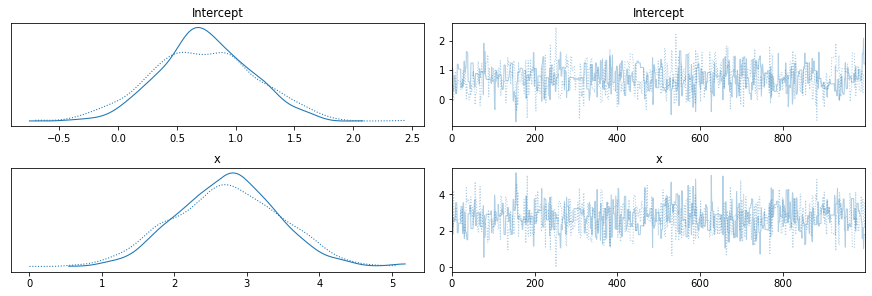

In [35]:
pm.plots.traceplot(trace)

/Users/gmingas/opt/anaconda3/envs/testenv/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

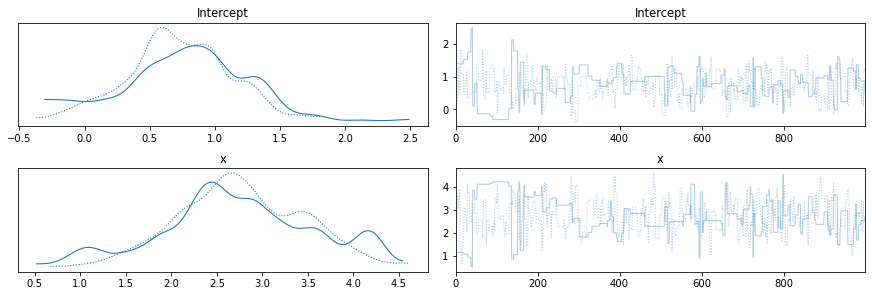

In [36]:
pm.plots.traceplot(trace2)

In [37]:
Q_1 = trace.get_sampler_stats("Q_1").reshape((nchains, ndraws))
Q_0 = np.concatenate(trace.get_sampler_stats("Q_0")).reshape((nchains, ndraws * nsub))
Q_1_0 = np.concatenate(trace.get_sampler_stats("Q_1_0")).reshape((nchains, ndraws ))
#Q_2_1 = np.concatenate(trace.get_sampler_stats("Q_2_1")).reshape((nchains, ndraws))
Q_mean_standard = Q_1.mean(axis=1).mean()
Q_mean_vr = (Q_0.mean(axis=1) + Q_1_0.mean(axis=1)).mean()

print(f"Q_0 mean = {Q_0.mean(axis=1)}")
print(f"Q_1 mean = {Q_1.mean(axis=1)}")
print(f"Q_1_0 mean = {Q_1_0.mean(axis=1)}")
#print(f"Q_2_1 mean = {Q_2_1.mean(axis=1)}")
print(f"Standard method:    Mean: {Q_mean_standard}")
print(f"VR method:    Mean: {Q_mean_vr}")



Q_0 mean = [2.88379706 2.84502645]
Q_1 mean = [2.7414882269463927 2.714680436069111]
Q_1_0 mean = [0. 0.]
Standard method:    Mean: 2.728084331507752
VR method:    Mean: 2.864411756646664


In [38]:
Q_1.shape

(2, 1000)

In [39]:
Q_1_0[1].var()

0.0

In [40]:
Q_0.mean(), Q_1.mean(), Q_1_0.mean()

(2.864411756646664, 2.7280843315077625, 0.0)

In [41]:
Q_1.var(axis=1), Q_0.var(axis=1), Q_1_0.var(axis=1)

(array([0.46348204435188545, 0.5733710304722078], dtype=object),
 array([0.86955846, 1.0274849 ]),
 array([0., 0.]))

(array([  7.,   1.,   0.,   2.,   2.,   9.,   2.,   0.,   0.,   4.,   1.,
          1.,   3.,   3.,   2.,  10.,   8.,   2.,   4.,  12.,   1.,  15.,
          7.,   1.,  17.,  14.,   4.,  13.,  11.,  20.,  26.,  21.,  17.,
         18.,  15.,  13.,  15.,  23.,   1.,  21.,  19.,  26.,  38.,  15.,
         42.,  32.,  21.,  20.,  17.,  43.,  13.,  31.,  67.,  37.,  39.,
         56.,  39.,  63.,  51.,  58.,  11.,  49.,  38.,  34.,  44.,  47.,
         59.,  25.,  46.,  43.,  68.,  73.,  39.,  41.,  60.,  27.,  38.,
         59.,  51.,  70.,  51.,  81.,  64.,  67., 111., 119.,  30.,  40.,
         96.,  77.,  41.,  69.,  44.,  84.,  38.,  32.,  78.,  49.,  52.,
         76.,  63.,  36.,  36.,  51.,  46.,  30.,  73.,  41.,  39.,  65.,
         26.,  64.,  26.,  38.,  32.,  46.,  64.,  47.,  33.,  71.,  14.,
         36.,  64.,  35.,  30.,  26.,  35.,  26.,  15.,  32.,  16.,  36.,
         26.,  17.,  33.,  23.,  10.,  17.,  18.,   7.,   9.,  16.,  21.,
         25.,  23.,   0.,   1.,   1., 

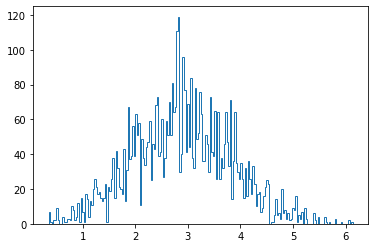

In [42]:
plt.hist(Q_0[0], bins=200, histtype='step')

In [43]:
Q_1


array([[array(1.83695331), array(1.83695331), array(1.83695331), ...,
        array(1.79339441), array(1.79339441), array(1.79339441)],
       [array(2.00313624), array(3.43822315), array(3.43822315), ...,
        array(2.14786772), array(3.53611696), array(3.53611696)]],
      dtype=object)

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
      

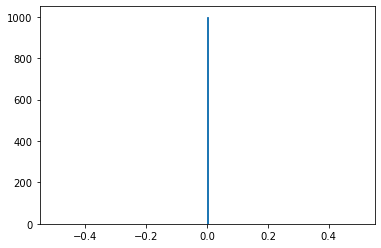

In [44]:
plt.hist(Q_1_0[0,:], bins=500, histtype='step')

In [45]:
import arviz
ess_Q1 = arviz.ess(np.array(Q_1,np.float64))
ess_Q0 = arviz.ess(np.array(Q_0,np.float64))
ess_Q_1_0 = arviz.ess(np.array(Q_1_0,np.float64))
#ess_Q_2_1 = arviz.ess(np.array(Q_2_1,np.float64))

In [46]:
ess_Q1, ess_Q0, ess_Q_1_0

(569.5286408907249, 1464.2388243866155, 2000)

In [47]:
Q_1.var()/ess_Q1

0.0009105884490969458

In [48]:
Q_0.var()/ess_Q0

0.0006480482958056806

In [49]:
Q_1_0.var()/ess_Q_1_0

0.0

In [50]:
Q1_SE = Q_1.var() / arviz.ess(np.array(Q_1[0],np.float64))
Q0_SE = Q_0.var() / arviz.ess(np.array(Q_0[0],np.float64))
Q_1_0_SE = Q_1_0.var() / arviz.ess(np.array(Q_1_0[0],np.float64))
print("Standard method SE: " + str(Q1_SE))
print("VR method SE: " + str(Q0_SE + Q_1_0_SE))

Standard method SE: 0.002116230741895412
VR method SE: 0.0012482405497943618
